In [1]:
## Function to run multiple classifiers on same training/test sets

## Import sklearn packages for model building
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

def run_models(X_train, y_train, X_test, y_test, clfs, model_type='Balanced'):
    '''
    This function takes as inputs the training and test data (X_train, y_train, X_test, y_test), the sklearn 
    classifiers to use (as name:method signature dict), and a model_type label to indicate if the data is 
    class balanced. It returns a data frame containing some performance metrics for each classifier and a 
    dict of confusion matrices (name:confusion matrix) for each classifier. It also plots the ROC curve for
    each classifier.
    
    The sklearn classifiers that have been imported and tested include LogisticRegression, 
    GaussianNB, RandomForestClassifier, GradientBoostingClassifier, SVC, LinearSVC.
    
    Example:
    model_type = 'Non-balanced'
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'SVM': LinearSVC(C=1.0) 
            }

    report, conf_matrix = run_models(X_train, y_train, X_test, y_test, clfs, model_type)
    '''
    
## Variable names to be descriptive

    ## Columns for performance metrics table 
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']
    models_report = pd.DataFrame(columns = cols)
    
    ## Confusion Matrix initialization
    conf_matrix = dict()

    ## Fit model for each classifier type and compute performance metrics
    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        print('Computing {} - {} '.format(clf_name, model_type))

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)[:,1]
        else:  # use decision function
            y_score = clf.decision_function(X_test)
            y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = confusion_matrix(y_test, y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(7,7))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc="lower right", prop={'size':11})


    plt.plot([0,1],[0,1], color = 'black')

    return models_report, conf_matrix

In [2]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    '''
    This function takes as inputs the confusion matrix (from sklearn.metrics.confusion_matrix) and a 
    list of class names, and prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    title and color map can be set as well.
    
    Example:
    
    class_names = ["Current","Default"]

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    '''
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()


In [17]:
## READ DATA
import pandas as pd
import numpy as np

periods = ['2016Q1','2016Q2','2016Q3','2016Q4','2017Q1','2017Q2','2017Q3'] #['2014','2015','2016Q1','2016Q2','2016Q3','2016Q4','2017Q1','2017Q2','2017Q3']
cols_to_keep = ['application_type','fico_range_high','grade','loan_status','loan_amnt','purpose','annual_inc','total_bal_ex_mort','all_util','revol_util','dti','emp_length','term','int_rate','issue_d','last_pymnt_d','total_rec_prncp','total_rec_late_fee','earliest_cr_line','mths_since_last_delinq','mths_since_last_major_derog','acc_open_past_24mths','inq_last_6mths']
data = pd.concat([pd.read_csv("LoanStats_{}.csv".format(period),sep="|",header=0,usecols=cols_to_keep) for period in periods], ignore_index=True, verify_integrity=True)

## Memory used in MB
data.memory_usage().sum()/1e6

139.71827200000001

In [18]:
## PREPARE DATA FOR ANALYSIS
## Keep only Individual Application types -- joint applications have different columns
data = data[data.application_type=='Individual']

## Convert loan_amnt to float for normalizations
data['loan_amnt'] = data['loan_amnt'].astype('float')

## Convert emp_length to numeric from string
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype(float)
data['emp_length'].fillna(value=0.0,inplace=True)

## Convert term to integer
data['term'] = data['term'].str.split(' ').str[1]

## Convert int_rate to a float
data['int_rate'] = data['int_rate'].str.split('%').str[0]
data['int_rate'] = data.int_rate.astype(float)/100.0

## Compute dti_rate (estimate) and set red flag if it is not as high as interest rate on current loan
data['dti_rf']=np.where(0.01*data['dti']*data['annual_inc']/data['total_bal_ex_mort']<data['int_rate']+0.16,1,0)

## Compute length of credit history at loan issue
data['credit_hist_length'] = (pd.to_datetime(data['issue_d'],format="%b-%Y") - pd.to_datetime(data['earliest_cr_line'],format="%b-%Y")).dt.days/365

## Compute period before loan became delinquent
data['period_non_delinq'] = (pd.to_datetime(data['last_pymnt_d'],format="%b-%Y") - pd.to_datetime(data['issue_d'],format="%b-%Y")).dt.days/365

## Normalize total principal received
data['frac_rec_prncp'] = data['total_rec_prncp']/data['loan_amnt']

## Categorize if borrower was ever late in loan payments
data['never_late'] = np.where(data['total_rec_late_fee']>0,0,1)

## Categorize if borrower was ever delinquent in last 2yrs, or had a major derogatory in credit report
data['never_delinq'] = np.where(pd.notna(data['mths_since_last_delinq']) & data['mths_since_last_delinq']>0,0,1)
data['never_derog'] = np.where(pd.notna(data['mths_since_last_major_derog']) & data['mths_since_last_major_derog']>0,0,1)

## Delete columns not needed any more
delete_cols = ['annual_inc','int_rate','total_bal_ex_mort','application_type','earliest_cr_line','last_pymnt_d','mths_since_last_delinq','mths_since_last_major_derog','total_rec_late_fee','total_rec_prncp']
data.drop(delete_cols , axis=1, inplace=True)

## Set up features list for later model building
features = ['never_late','frac_rec_prncp','fico_range_high','acc_open_past_24mths','never_delinq','never_derog','inq_last_6mths','credit_hist_length','emp_length','dti','dti_rf']

## Categorize based on loan purpose
loan_purpose_list = ['car','credit_card','debt_consolidation','home_improvement','major_purchase','medical','moving','small_business','vacation']
for purpose in loan_purpose_list:
    colname = purpose+'_loan'
    data[colname] = np.where(data['purpose']==purpose,1,0)
    features.append(colname)
    
loan_purpose_list.append('other')
data['other_loan'] = np.where(data['purpose'].isin(loan_purpose_list),0,1)
features.append('other_loan')

## Delete columns not needed any more
delete_cols = ['issue_d','purpose']
data.drop(delete_cols , axis=1, inplace=True)

## Create new loan delinquent column based on loan_status
data['loan_delinq']=np.where(data['loan_status'].isin(["Current","Fully Paid","In Grace Period"]),0,np.where(data['period_non_delinq']>1.05,0,1))

## Group by loan delinquency and get sizes
data.groupby("loan_delinq").size()

/home/pallav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


loan_delinq
0    686752
1     38583
dtype: int64

In [19]:
## Prepare data for models
features.insert(0,'loan_delinq')
X = data[features]

# Drop any residual missing value (only 1)
X.dropna(axis=0, how = 'any', inplace = True)
y = X['loan_delinq']
X=X[features[1:]]
print(len(X))

725334


/home/pallav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
## Scale data
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)
len(X)

725334

In [22]:
## Split data into train/test sets
from sklearn.model_selection import train_test_split #, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.25, random_state=0)

print(len(X_train))
print(len(y_train))
print(sum(y_train))

print(len(X_test))
print(len(y_test))

544000
544000
28869
181334
181334


In [23]:
## Oversample the training data using SMOTE package if model_type is `Balanced`
from imblearn.over_sampling import SMOTE

#model_type = 'Non-balanced'
model_type = 'Balanced'

if model_type == 'Balanced':
    X_train, y_train = SMOTE().fit_sample(X_train, y_train)

print(len(y_train))
print(sum(y_train))

1030262
515131


Computing GradientBoosting - Balanced 
Computing LogisticRegression - Balanced 
Computing RandomForest - Balanced 
Computing NaiveBayes - Balanced 
Computing SVM - Balanced 


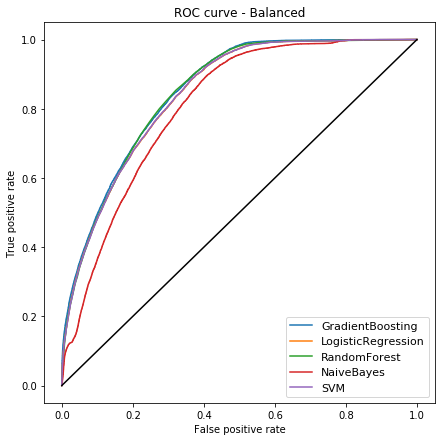

In [24]:
## Set up classifiers and run models
clfs = {
        'GradientBoosting': GradientBoostingClassifier(max_depth=6, n_estimators=100, max_features = 0.3),
        'LogisticRegression' : LogisticRegression(),
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'NaiveBayes': GaussianNB(),
        'SVM': LinearSVC(C=1.0),
        }

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, clfs, model_type)

In [25]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.273222,0.851946,0.251344,0.413939,0.312772,Balanced
1,LogisticRegression,0.243634,0.844211,0.132418,0.806259,0.227476,Balanced
2,RandomForest,0.256104,0.848632,0.341736,0.245625,0.285817,Balanced
3,NaiveBayes,0.219421,0.806780,0.132331,0.697550,0.222459,Balanced
4,SVM,0.242914,0.844201,0.129985,0.822009,0.224474,Balanced


In [26]:
print(conf_matrix['GradientBoosting'])
print(conf_matrix['LogisticRegression'])
print(conf_matrix['RandomForest'])
print(conf_matrix['NaiveBayes'])
print(conf_matrix['SVM'])

[[159643  11977]
 [  5693   4021]]
[[120306  51314]
 [  1882   7832]]
[[167024   4596]
 [  7328   2386]]
[[127191  44429]
 [  2938   6776]]
[[118175  53445]
 [  1729   7985]]


Confusion matrix, without normalization
[[120306  51314]
 [  1882   7832]]


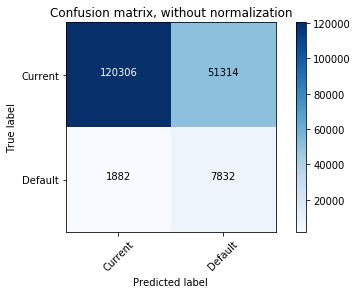

Normalized confusion matrix
[[ 0.70100221  0.29899779]
 [ 0.19374099  0.80625901]]


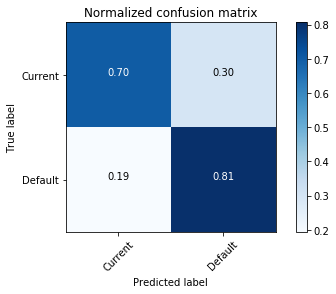

In [27]:
## Plot confusion matrix

class_names = ["Current","Default"]

# non-normalized confusion matrix
plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names, title='Confusion matrix, without normalization')

# normalized confusion matrix
plot_confusion_matrix(conf_matrix['LogisticRegression'], classes=class_names, normalize=True,title='Normalized confusion matrix')

In [28]:
## Use statsmodels Logistic Regression to get model coefs and  

import statsmodels.discrete.discrete_model as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

model = sm.Logit(y_train, X_train)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.552510
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1030262
Model:                          Logit   Df Residuals:                  1030241
Method:                           MLE   Df Model:                           20
Date:                Fri, 02 Feb 2018   Pseudo R-squ.:                  0.2029
Time:                        12:46:33   Log-Likelihood:            -5.6923e+05
converged:                       True   LL-Null:                   -7.1412e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2062      0.002    -98.509      0.000      -0.210      -0.202
x2            -1.0803      0.

In [32]:
features

['loan_delinq',
 'never_late',
 'frac_rec_prncp',
 'fico_range_high',
 'acc_open_past_24mths',
 'never_delinq',
 'never_derog',
 'inq_last_6mths',
 'credit_hist_length',
 'emp_length',
 'dti',
 'dti_rf',
 'car_loan',
 'credit_card_loan',
 'debt_consolidation_loan',
 'home_improvement_loan',
 'major_purchase_loan',
 'medical_loan',
 'moving_loan',
 'small_business_loan',
 'vacation_loan',
 'other_loan']

1030262
1030262
181334
181334
Computing LogisticRegression - Balanced 
Computing NaiveBayes - Balanced 
Computing SVM - Balanced 


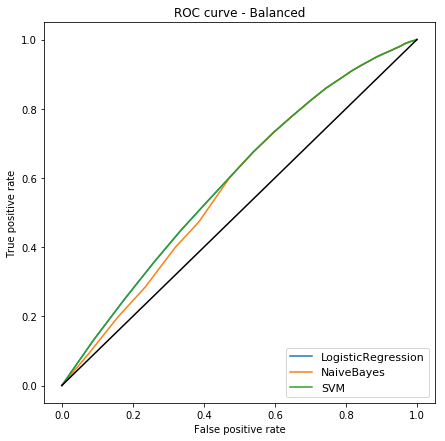

In [29]:
## 1-factor FICO score model as baseline
Xs_train = X_train[:,2:3]
Xs_test = X_test[:,2:3]
model_type = 'Balanced'
#model_type = 'Non-balanced'

print(len(Xs_train))
print(len(y_train))
print(len(Xs_test))
print(len(y_test))

clfs = {
        'LogisticRegression' : LogisticRegression(),
        'NaiveBayes': GaussianNB(),
        'SVM': LinearSVC(C=1.0),
        }

models_report_1f, conf_matrix_1f = run_models(Xs_train, y_train, Xs_test, y_test, clfs, model_type)

In [30]:
models_report_1f

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.061382,0.590650,0.066174,0.674387,0.120522,Balanced
1,NaiveBayes,0.061067,0.578819,0.062436,0.823245,0.116068,Balanced
2,SVM,0.061382,0.590650,0.066174,0.674387,0.120522,Balanced


In [31]:
print(conf_matrix_1f['LogisticRegression'])
print(conf_matrix_1f['NaiveBayes'])
print(conf_matrix_1f['SVM'])
print(len(y_test))


[[79175 92445]
 [ 3163  6551]]
[[ 51533 120087]
 [  1717   7997]]
[[79175 92445]
 [ 3163  6551]]
181334
